In [190]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt

parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.insert(0, parent_dir)

from utils import loader, load_data, nrpd_accuracy_channel_plot

### 0. Load forecast_v1, forecast_v2 (new), actual NRPD data

In [32]:
## Load data
# v2_forecast_by_channel
nrpd_forecast_v2 = pd.read_csv('../outputs/2024-10-11-11-10-24/nrpd_forecast.csv')

# Change dtypes to datetime
nrpd_forecast_v2['forecast_month'] = pd.to_datetime(nrpd_forecast_v2['forecast_month'])
nrpd_forecast_v2['month'] = pd.to_datetime(nrpd_forecast_v2['month'])

nrpd_forecast_v2.sort_values(['forecast_month', 'channels', 'month'], inplace=True, ignore_index=True)
nrpd_forecast_v2.rename({'forecast_nrpd_by_incre_channel' : 'nrpd_forecast_v2'}, axis=1, inplace=True)

In [31]:
# v1_forecast_by_channel
rs = loader()
nrpd_forecast_v1 = load_data(
    sql_path=os.path.join(parent_dir, 'sql/nrpd_old_forecast.sql'),
    loader=rs
)

# Change dtypes to datetime
nrpd_forecast_v1['signup_month'] = pd.to_datetime(nrpd_forecast_v1['signup_month'])
nrpd_forecast_v1.rename({'net_revenue_per_paid_day' : 'nrpd_forecast_v1'}, axis=1, inplace=True)

/Users/timkim/Library/Caches/pypoetry/virtualenvs/nrpd-forecast-WVTmGF-7-py3.10/lib/python3.10/site-packages/python_ml_common/loader/redshift.py:61: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)


In [72]:
# actual data
nrpd_actual = load_data(
    sql_path=os.path.join(parent_dir, 'sql/nrpd_actual.sql'),
    loader=rs
)

# Change dtypes to datetime
nrpd_actual['month'] = pd.to_datetime(nrpd_actual['month'])
nrpd_actual.rename({'nrpd' : 'nrpd_actual'}, axis=1, inplace=True)

nrpd_actual['signup_month'] = nrpd_actual.apply(lambda row: row['month'] - pd.DateOffset(months=row['increments_from_signup']-1), axis=1)

In [170]:
## Merge all three
nrpd_forecasts = pd.merge(nrpd_forecast_v2, nrpd_forecast_v1, how='left', left_on=['channels', 'forecast_month', 'increments_from_signup'], right_on=['channels', 'signup_month', 'increments_from_signup'])
nrpd_all = pd.merge(nrpd_forecasts, nrpd_actual, how='left', on=['channels', 'month', 'increments_from_signup'])
nrpd = nrpd_all[['scenario', 'forecast_month', 'channels', 'month', 'data_volume_y', 'paid_days', 'nrpd_forecast_v2', 'nrpd_forecast_v1', 'nrpd_actual']].copy()

### 1. Accuracy

#### (a) Channel-level accuracy

In [208]:
# Channels included for payback period calculation
payback_channels = ['Apple','Google_Desktop','Google_Desktop_Brand','Google_Discovery',
    'Google_Mobile','Google_Mobile_Brand','Google_UAC_Android','Kayak_Desktop',
    'Kayak_Desktop_Core', 'Kayak_Mobile_Core','Mediaalpha','Expedia','Microsoft_Desktop',
    'Microsoft_Desktop_Brand','Microsoft_Mobile', 'Microsoft_Mobile_Brand','Kayak_Desktop_Front_Door',
    'Kayak_Desktop_Compare','Google_Pmax','Kayak_Desktop_Carousel','Kayak_Mobile_Carousel',
    'Kayak_Mobile','Kayak_Afterclick', 'Facebook/IG_App', 'Facebook/IG_Web']

# Keep only payback channels
nrpd_payback = nrpd.loc[nrpd.channels.isin(payback_channels)].reset_index(drop=True)

In [209]:
# Create a column for paid_days_weight
nrpd_payback['paid_days_weight'] = nrpd_payback.groupby(['scenario', 'forecast_month', 'channels'])['paid_days'].transform(lambda x: x/x.sum())

# Compute weighted forecast/actual nrpd values
nrpd_payback['w_nrpd_forecast_v2'] = nrpd_payback['nrpd_forecast_v2'] * nrpd_payback['paid_days_weight']
nrpd_payback['w_nrpd_forecast_v1'] = nrpd_payback['nrpd_forecast_v1'] * nrpd_payback['paid_days_weight']
nrpd_payback['w_nrpd_actual'] = nrpd_payback['nrpd_actual'] * nrpd_payback['paid_days_weight']

weighted_nrpd_payback = nrpd_payback.groupby(['scenario', 'forecast_month', 'channels'], as_index=False)[['w_nrpd_forecast_v2', 'w_nrpd_forecast_v1', 'w_nrpd_actual', 'data_volume_y']].sum()
weighted_nrpd_payback.sort_values(['forecast_month', 'channels'], inplace=True, ignore_index=True)

In [210]:
weighted_nrpd_payback[['w_nrpd_forecast_v2', 'w_nrpd_forecast_v1', 'w_nrpd_actual']] = weighted_nrpd_payback[['w_nrpd_forecast_v2', 'w_nrpd_forecast_v1', 'w_nrpd_actual']].replace(0, np.nan)

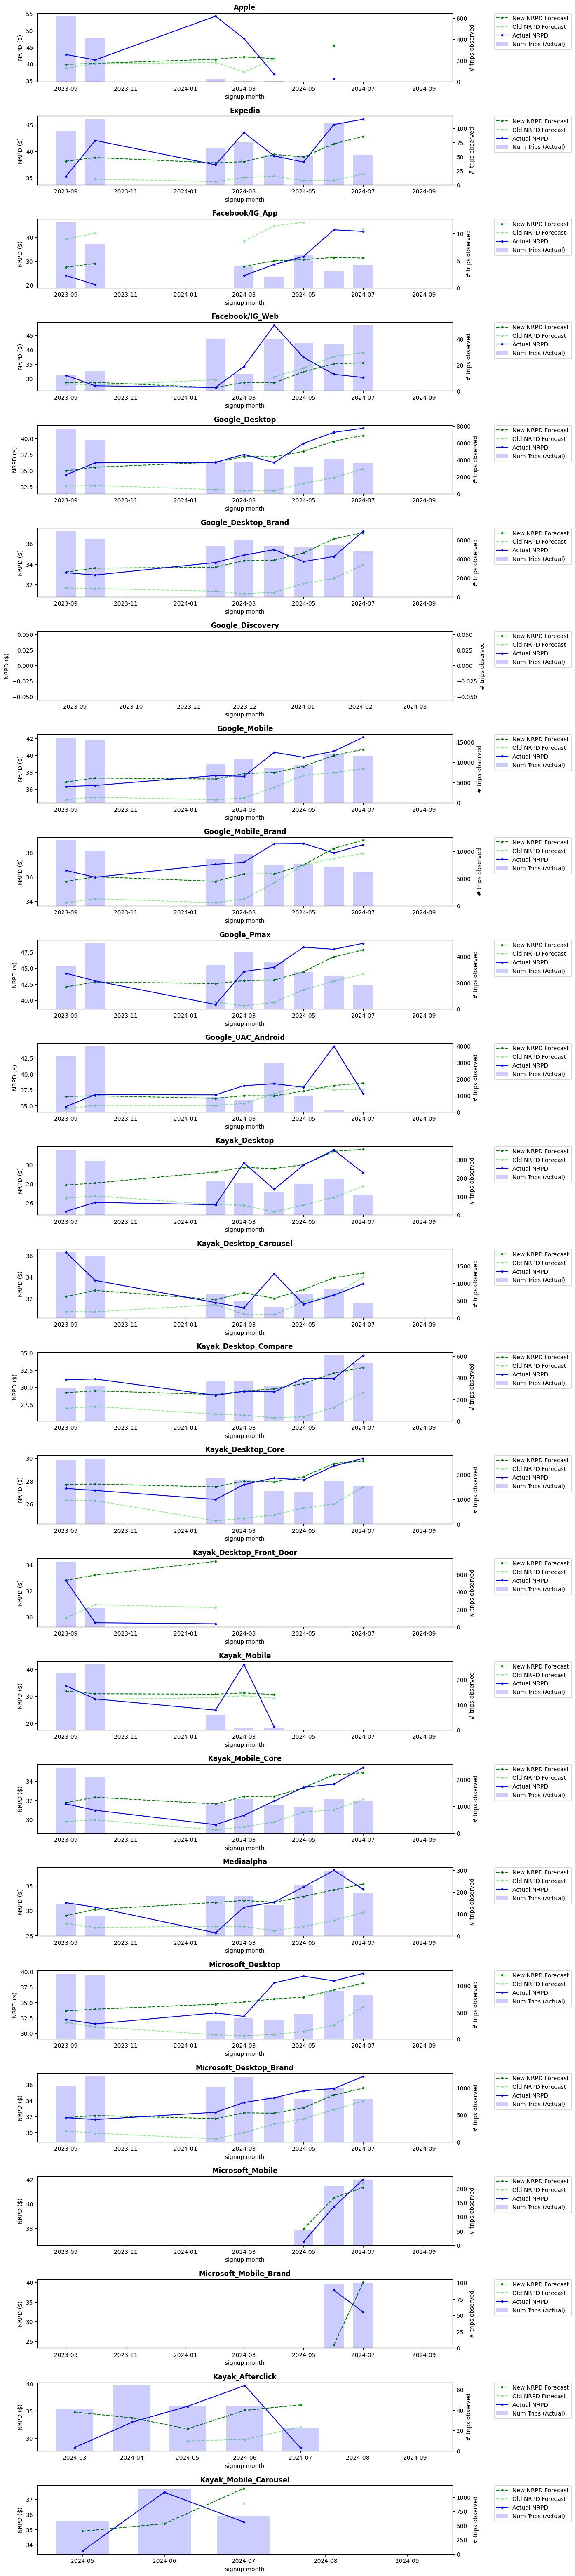

In [211]:
nrpd_accuracy_channel_plot(weighted_nrpd_payback)